In [ ]:
# import os
# import pandas as pd
# from pandas import ExcelWriter
# from pandas import ExcelFile

# import random as rnd
# import matplotlib.pyplot as plt
# from matplotlib.widgets import Button
# from matplotlib.text import Annotation


In [ ]:
# # Test 1
# labels_color_map = {0: 'red', 1: "blue"}
# no_examples = 20

# generated_data = [(x, rnd.randint(0, no_examples)) for x in range(0, no_examples)]
# generated_labels = ["Label for instance #{0}".format(i) for i in range(0, no_examples)]

# instances_colors = []
# axis_values_x = []
# axis_values_y = []

# for index, instance in enumerate(generated_data):
#     coordinate_x, coordinate_y = instance
#     color = labels_color_map[index % 2]
    
#     instances_colors.append(color)
#     axis_values_x.append(coordinate_x)
#     axis_values_y.append(coordinate_y)
    
# fig = plt.figure(figsize=(5,4))
# ax = plt.subplot()

# def draw_scatterplot():
#     ax.scatter(
#         axis_values_x,
#         axis_values_y,
#         c=instances_colors,
#         picker=True
#     )

# draw_scatterplot()
    
# # def annotate(axis, text, x,y):
# #     text_annotation = Annotation(text, xy=(x,y), xycoords="data")
# #     axis.add_artist(text_annotation)
    
# # annotate(axis, text, x,y)
    
# def onpick(event):
#     ind = event.ind
#     label_pos_x = event.mouseevent.xdata
#     label_pos_y = event.mouseevent.ydata
#     offset = 0
    
#     for i in ind:
#         label = generated_labels[i]
#         print("index", i, label)
#         annotate(
#             ax,
#             label,
#             label_pos_x + offset,
#             label_pos_y + offset)
#         ax.figure.canvas.draw_idle()
#         offset += 0.01

        
# fig.canvas.mpl_connect('button_press_event', onpick)


# ax_clear_all = plt.axes([0.0, 0.0, 0.5, 0.05])
# button_clear_all = Button(ax_clear_all, "Click Here to Clear all")

# def onclick(event):
#     ax.cla
#     draw_scatterplt()
#     ax.figure.canvas.draw_idle()
    
# button_clear_all.on_clicked(onclick)

# plt.plot()
# plt.show

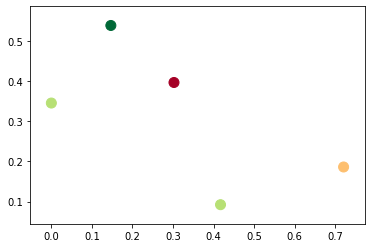

In [1]:
# EXAMPLE 2

import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)

x = np.random.rand(5)
y = np.random.rand(5)
names = np.array(list("ABCDEFGHIJKLMNO"))
c = np.random.randint(1,5,size=5)

norm = plt.Normalize(1,4)
cmap = plt.cm.RdYlGn

fig,ax = plt.subplots()
sc = plt.scatter(x,y,c=c, s=100, cmap=cmap, norm=norm)

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
                           " ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()

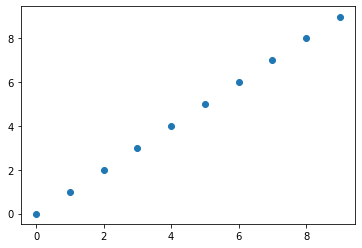

In [20]:
x = range(10)
y = range(10)
annotes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

fig, ax = plt.subplots()
ax.scatter(x,y)
af =  AnnoteFinder(x,y, annotes, ax=ax)
fig.canvas.mpl_connect('button_press_event', af)
plt.show()